In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

# Online Outcomes: Predicting Success in Virtual Learning

**<font size="4">Author: Jeffrey Hanif Watson</font>**

## Imports and Project Path

In [2]:
# importing packages
import os, sys
import pandas as pd
import numpy as np
import sqlite3

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from dython.nominal import associations

from src import class_Database as d
from src import helper_functions as f
from src import visualizations as v

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

time: 2.76 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.18 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 436 µs


## Creating SQL `conn`, `cur`

In [5]:
data_path = os.path.join(gparent,'data/processed','outcomes.db')
conn = sqlite3.connect(data_path)  
cur = conn.cursor()

time: 1.68 ms


### Database ERD

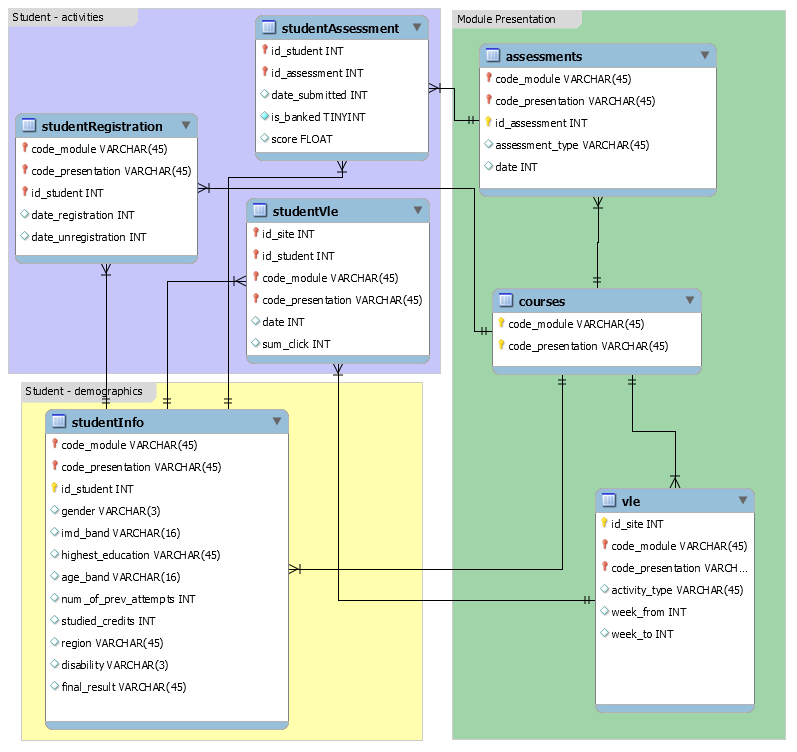

time: 5.69 ms


In [6]:
db.erd

## EDA

### Checking table names

In [7]:
# checking the table names
db.table_names()

['ASSESSMENTS',
 'COURSES',
 'STUDENTASSESSMENT',
 'STUDENTINFO',
 'STUDENTREGISTRATION',
 'STUDENTVLE',
 'VLE']

time: 3.24 ms


## Data Understanding

### Codes & Module Summaries

In [8]:
# month codes used in code_presentation
db.month_codes

{'A': 'January',
 'B': 'Februrary',
 'C': 'March',
 'D': 'April',
 'E': 'May',
 'F': 'June',
 'G': 'July',
 'H': 'August',
 'I': 'Septemeber',
 'J': 'October',
 'K': 'November',
 'L': 'December'}

time: 2.4 ms


In [9]:
# module codes and summaries
db.module_codes

{'AAA': {'Domain': 'Social Sciences', 'Presentations': 2, 'Students': 748},
 'BBB': {'Domain': 'Social Sciences', 'Presentations': '4', 'Students': 7909},
 'CCC': {'Domain': 'STEM', 'Presentations': 2, 'Students': 4434},
 'DDD': {'Domain': 'STEM', 'Presentations': 4, 'Students': 6272},
 'EEE': {'Domain': 'STEM', 'Presentations': 3, 'Students': 2934},
 'FFF': {'Domain': 'STEM', 'Presentations': 4, 'Students': 7762},
 'GGG': {'Domain': 'Social Sciences', 'Presentations': 3, 'Students': 2534}}

time: 3.01 ms


## Student Info Table

In [10]:
# creating student_info data frame
student_info = db.simple_df('STUDENTINFO')

time: 185 ms


In [11]:
# checking first five rows
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


time: 21.1 ms


In [12]:
# checking info
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB
time: 25.7 ms


In [13]:
# checking for nulls
student_info.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

time: 25 ms


We have 1100 null values in the imd_band column. We'll drop them for now.

In [14]:
# dropping nulls
student_info = student_info.dropna()

time: 31.7 ms


In [15]:
# checking work
student_info.isna().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

time: 22.6 ms


In [16]:
# checking new shape
student_info.shape

(31482, 12)

time: 2.54 ms


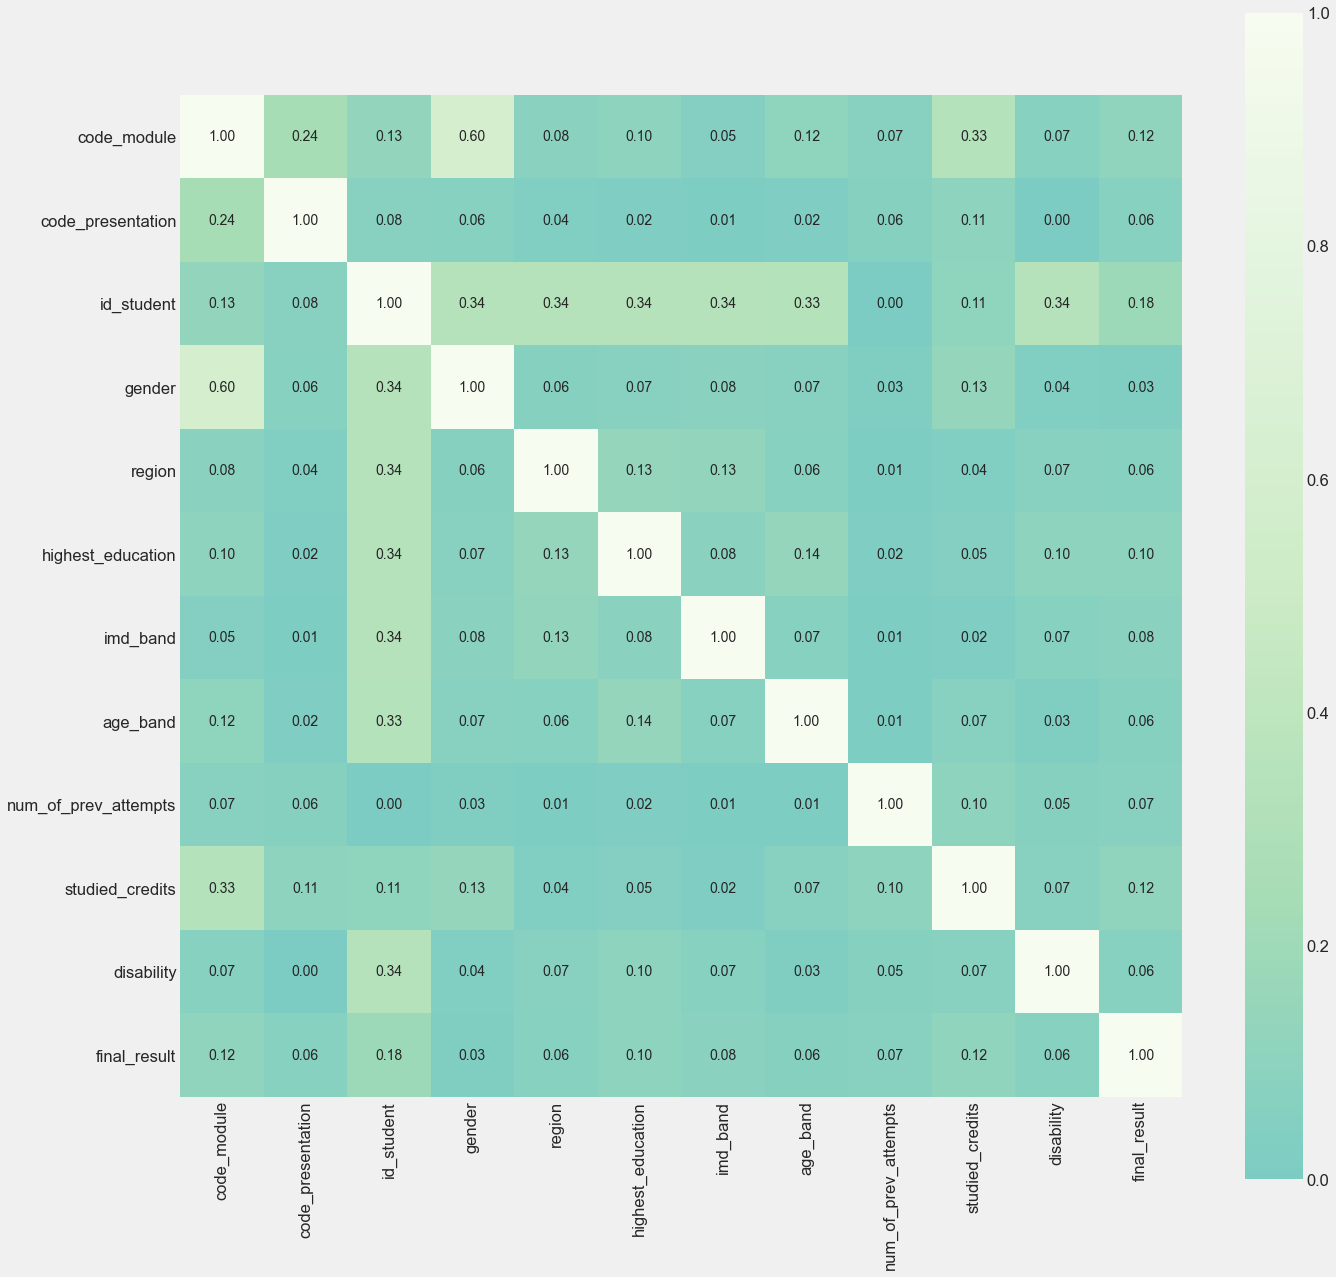

time: 15.7 s


In [17]:
corr1 = associations(student_info, figsize=(20,20), cmap='GnBu_r')

### Share of Outcomes By Type

In [18]:
student_info.final_result.value_counts(normalize=True)

Pass           0.375770
Withdrawn      0.315101
Fail           0.219395
Distinction    0.089734
Name: final_result, dtype: float64

time: 8.2 ms


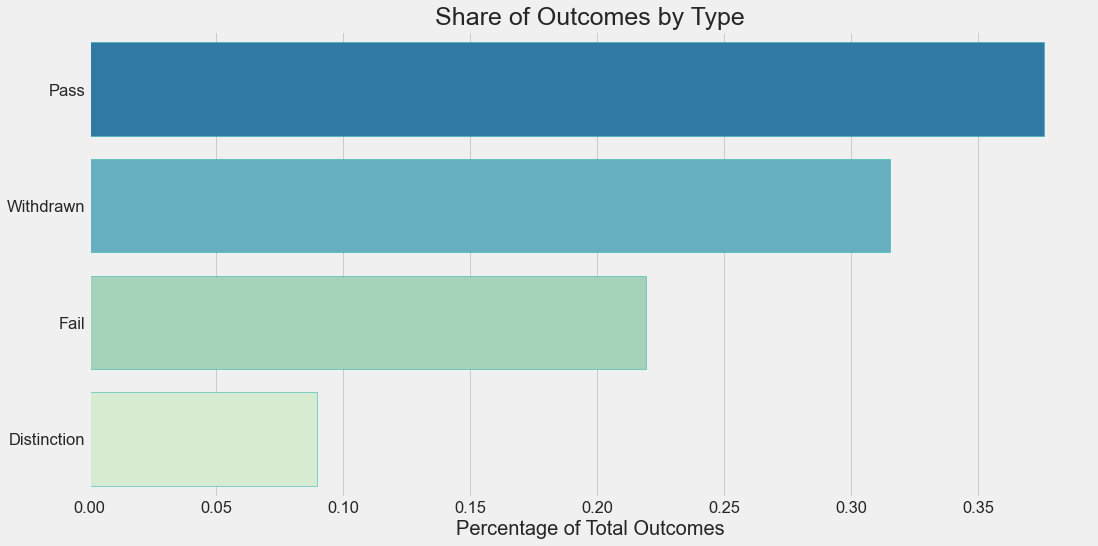

time: 283 ms


In [19]:
v.outcomes_type(student_info, 'outcomes_type')

### Outcomes By IMD Band

In [20]:
student_info['imd_band'].unique()

array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%',
       '60-70%', '40-50%', '10-20', '0-10%'], dtype=object)

time: 9.52 ms


In [21]:
student_info['imd_band'].value_counts(normalize=True)

20-30%     0.116066
30-40%     0.112413
10-20      0.111683
0-10%      0.105171
40-50%     0.103424
50-60%     0.099231
60-70%     0.092275
70-80%     0.091449
80-90%     0.087733
90-100%    0.080554
Name: imd_band, dtype: float64

time: 7.34 ms


In [22]:
# fixing typo
student_info['imd_band'] = student_info['imd_band'].replace(['10-20'], '10-20%')

time: 6.9 ms


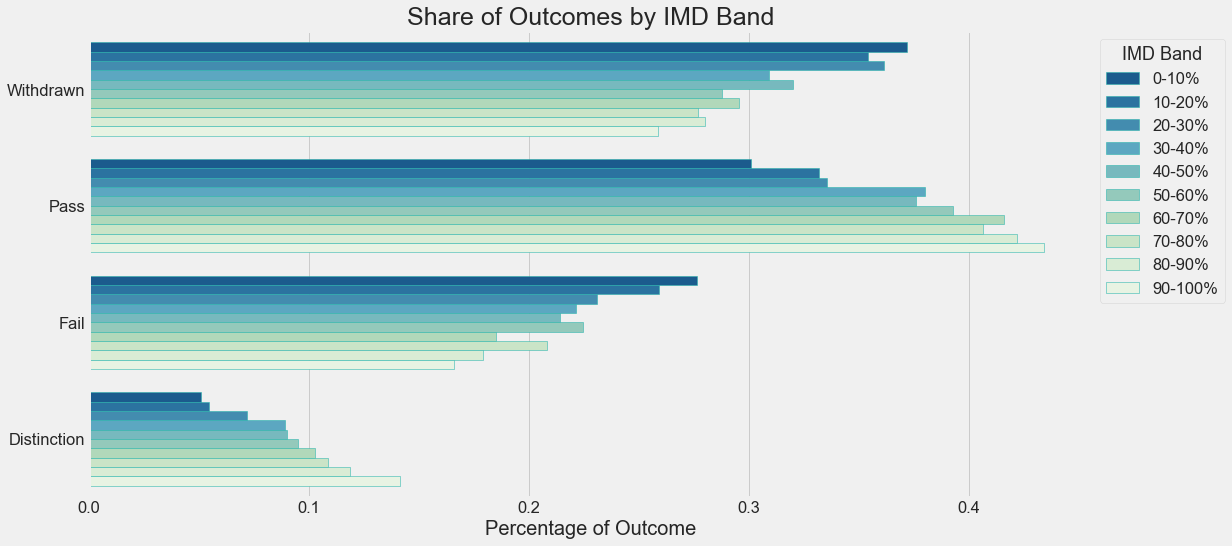

time: 570 ms


In [23]:
v.outcomes_imd(student_info, 'outcomes_imd')

### Outcomes By Disability Status

In [24]:
student_info['disability'].value_counts(normalize=True)

N    0.900546
Y    0.099454
Name: disability, dtype: float64

time: 5.49 ms


In [25]:
# renaming values
student_info['disability'] = student_info['disability'].replace(['Y', 'N'], ['Yes', 'No'])

time: 4.51 ms


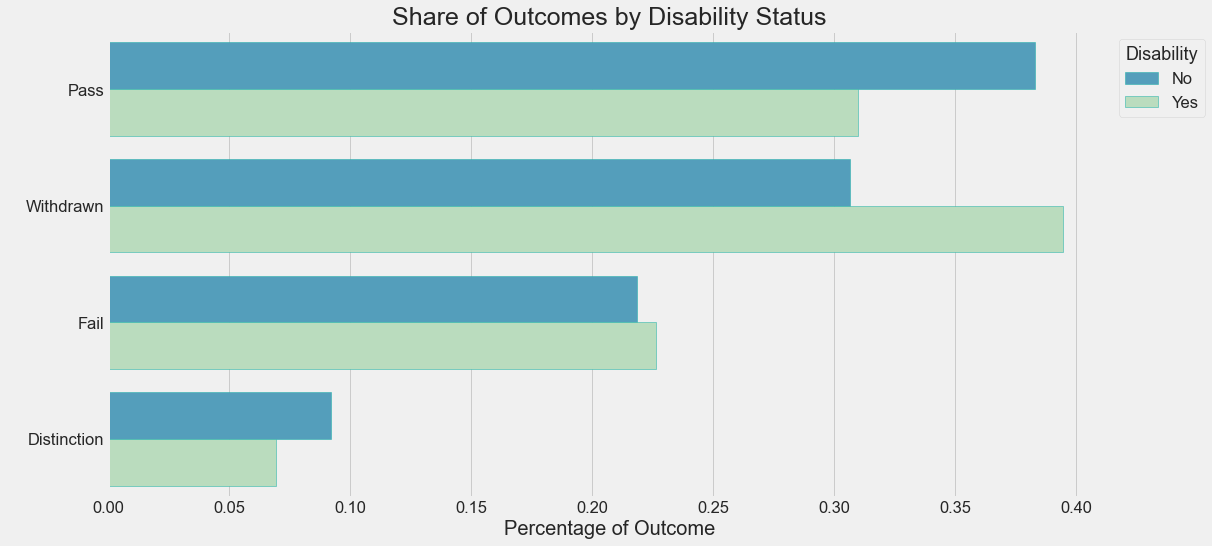

time: 346 ms


In [26]:
v.outcomes_dis(student_info, 'outcomes_dis')

### Outcomes By Age Band

In [27]:
student_info.age_band.value_counts(normalize=True)

0-35     0.707452
35-55    0.286164
55<=     0.006385
Name: age_band, dtype: float64

time: 12.7 ms


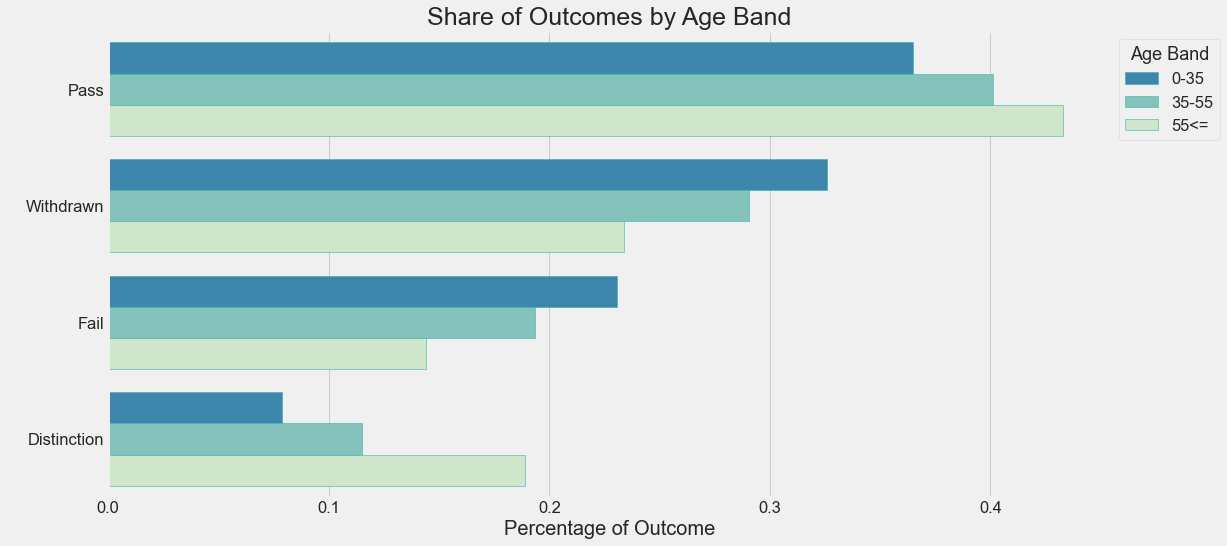

time: 406 ms


In [28]:
v.outcomes_age(student_info, 'outcomes_age')

### Outcomes By Education Level

In [29]:
student_info.highest_education.value_counts(normalize=True)

A Level or Equivalent          0.437139
Lower Than A Level             0.405374
HE Qualification               0.141160
No Formal quals                0.010419
Post Graduate Qualification    0.005908
Name: highest_education, dtype: float64

time: 9.16 ms


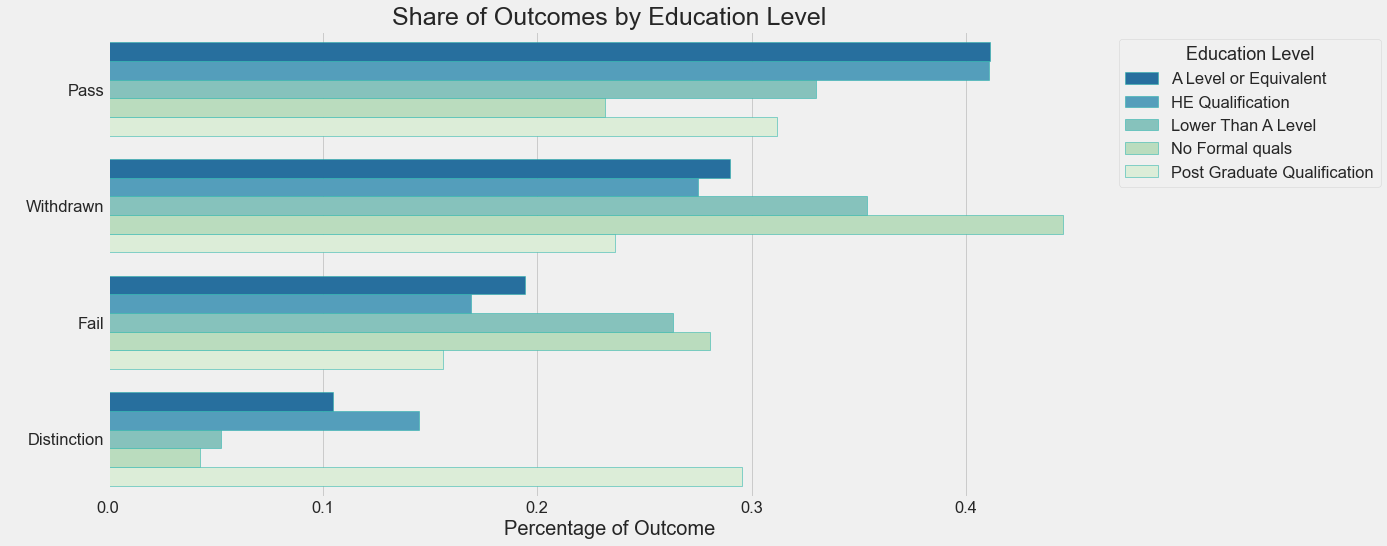

time: 409 ms


In [30]:
v.outcomes_edu(student_info, 'outcomes_edu')

### Outcomes By Gender

In [31]:
student_info.gender.value_counts(normalize=True)

M    0.542119
F    0.457881
Name: gender, dtype: float64

time: 7.73 ms


In [32]:
# renaming values
student_info['gender'] = student_info['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 4.22 ms


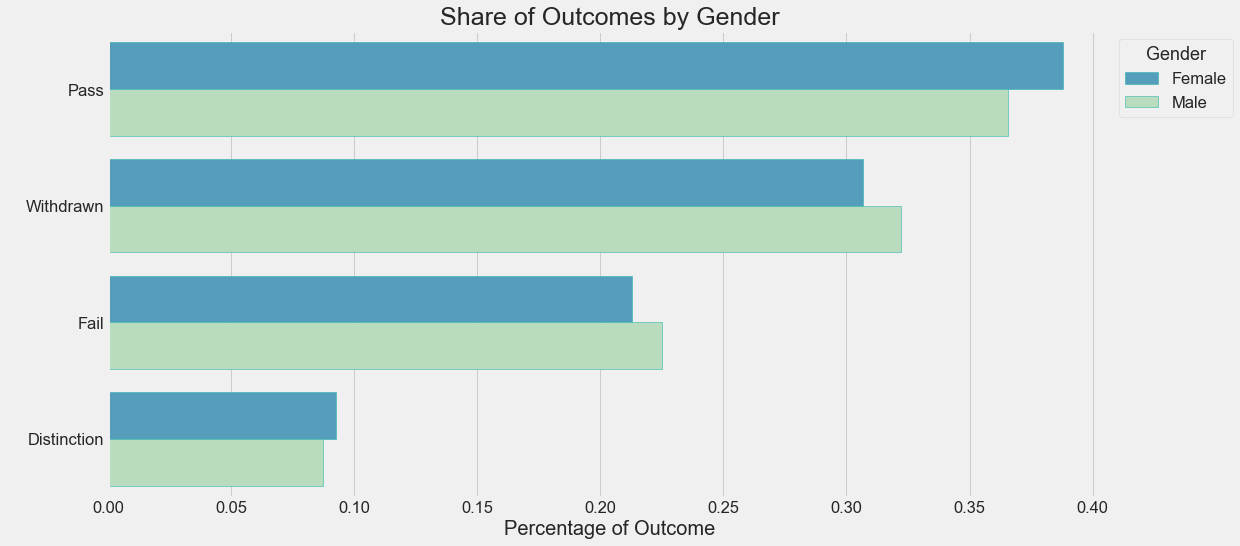

time: 360 ms


In [33]:
v.outcomes_gen(student_info, 'outcomes_gen')

### Outcomes by Region

In [34]:
student_info.region.value_counts(normalize=True)

Scotland                0.109078
East Anglian Region     0.106092
London Region           0.102154
South Region            0.096690
North Western Region    0.092148
West Midlands Region    0.080776
South West Region       0.077219
East Midlands Region    0.075122
South East Region       0.067054
Wales                   0.066260
Yorkshire Region        0.063560
North Region            0.034686
Ireland                 0.029160
Name: region, dtype: float64

time: 10.4 ms


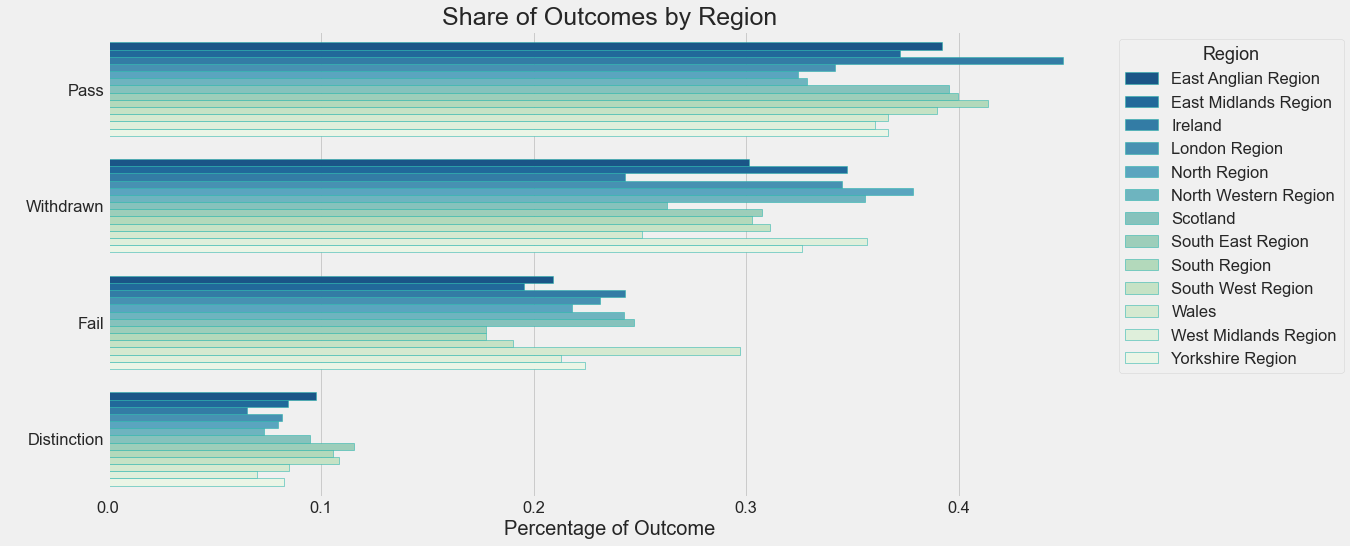

time: 363 ms


In [35]:
v.outcomes_reg(student_info)

### Outcomes by Course Load

In [36]:
# converting data type to numeric
student_info['studied_credits'] = student_info['studied_credits']\
.map(pd.to_numeric)

time: 328 ms


In [184]:
# checking summary stats
student_info['studied_credits'].describe() 

count    31482.000000
mean        79.767804
std         41.049455
min         30.000000
25%         60.000000
50%         60.000000
75%        120.000000
max        655.000000
Name: studied_credits, dtype: float64

time: 6.38 ms


## Will deal with outliers using fences.

### Median & Mean Study Credits

In [37]:
# checking mean
student_info.studied_credits.mean()

79.7678038244076

time: 3 ms


In [38]:
# checking median
student_info.studied_credits.median()

60.0

time: 3.25 ms


In [39]:
# binning data
pd.qcut(student_info.studied_credits, q=4, duplicates='drop').unique()

[(120.0, 655.0], (29.999, 60.0], (60.0, 120.0]]
Categories (3, interval[float64]): [(29.999, 60.0] < (60.0, 120.0] < (120.0, 655.0]]

time: 7.85 ms


### Adding `course_load` Category

In [40]:
# adding course_load category
student_info['course_load'] = pd.qcut(student_info.studied_credits, q=4,\
                                      labels=['Light', 'Medium', 'Heavy'],\
                                      duplicates='drop')

time: 5.28 ms


In [41]:
# checking work
print(f'{student_info.course_load.unique()} \n' )
student_info.info()

['Heavy', 'Light', 'Medium']
Categories (3, object): ['Light' < 'Medium' < 'Heavy'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31482 entries, 0 to 32592
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   code_module           31482 non-null  object  
 1   code_presentation     31482 non-null  object  
 2   id_student            31482 non-null  object  
 3   gender                31482 non-null  object  
 4   region                31482 non-null  object  
 5   highest_education     31482 non-null  object  
 6   imd_band              31482 non-null  object  
 7   age_band              31482 non-null  object  
 8   num_of_prev_attempts  31482 non-null  object  
 9   studied_credits       31482 non-null  int64   
 10  disability            31482 non-null  object  
 11  final_result          31482 non-null  object  
 12  course_load           31482 non-null  category
dtypes: category(1), int6

In [42]:
# checking value_counts
student_info.course_load.value_counts(normalize=True)

Light     0.631091
Medium    0.299536
Heavy     0.069373
Name: course_load, dtype: float64

time: 4.29 ms


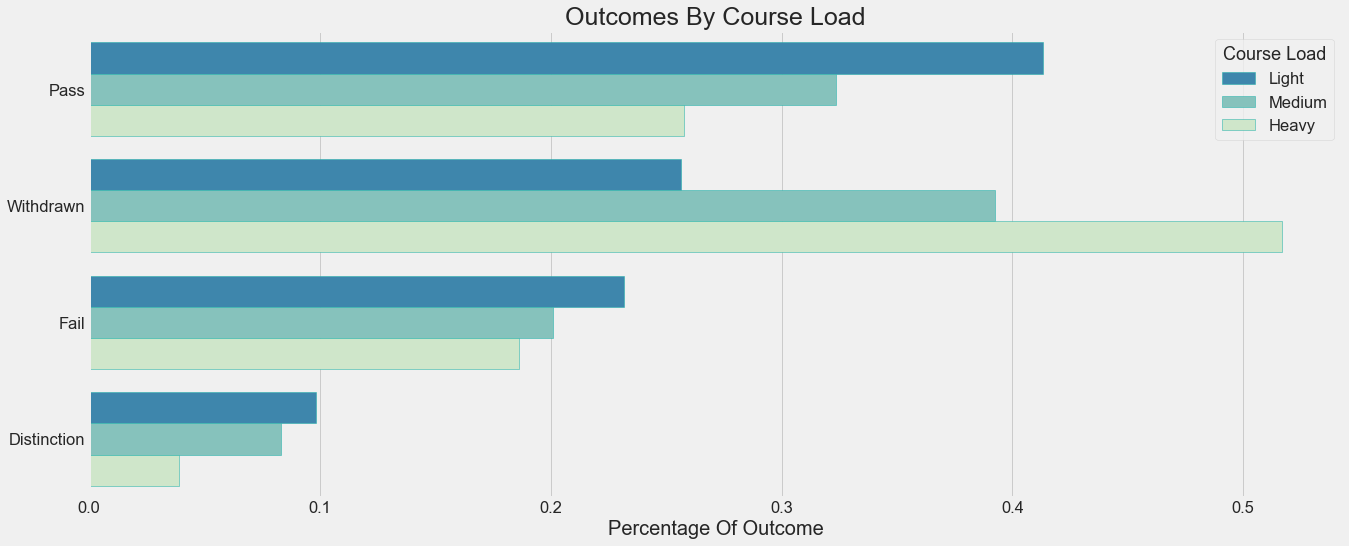

time: 378 ms


In [43]:
v.outcome_cl(student_info, 'outcomes_cl')

### Binarizing the Target

In [44]:
student_info = f.binarize_target(student_info)

time: 10.7 ms


In [45]:
student_info.head(2)

,target,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,course_load
0,1,AAA,2013J,11391,Male,East Anglian Region,HE Qualification,90-100%,55<=,0,240,No,Pass,Heavy
1,1,AAA,2013J,28400,Female,Scotland,HE Qualification,20-30%,35-55,0,60,No,Pass,Light


time: 9.58 ms


## Joining STUDENTINFO & STUDENTVLE Tables (SQL)

In [46]:
# getting column names and table info
q= "PRAGMA table_info(STUDENTVLE);"
f.fetch(cur, q)

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'id_site', 'TEXT', 0, None, 0),
 (4, 'date', 'TEXT', 0, None, 0),
 (5, 'sum_click', 'TEXT', 0, None, 0)]

time: 3.57 ms


In [47]:
q = """
SELECT SV.*, 
SUM(SV.sum_click) AS click_sum,
COUNT(SV.sum_click) AS num_activities,
SI.*
FROM 
STUDENTVLE as SV
JOIN 
STUDENTINFO as SI
ON SV.code_module = SI.code_module
AND SV.code_presentation = SI.code_presentation
AND SV.id_student = SI.id_student
GROUP BY 
SV.code_module,
SV.code_presentation,
SV.id_student;
"""
sv_si = pd.read_sql(q, conn)

time: 28.9 s


In [48]:
# cleaning up the data frame
sv_si = f.sv_si_fixes(sv_si)

time: 4.7 s


In [49]:
sv_si.head(2)

,target,final_result,code_module,code_presentation,id_student,id_site,date,click_sum,num_activities,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,course_load
0,1,Pass,AAA,2013J,100893,547013,-9,744,243,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,No,Light
1,1,Pass,AAA,2013J,101781,546614,-10,4104,913,Male,South Region,Lower Than A Level,80-90%,35-55,0,60,No,Light


time: 12.2 ms


In [50]:
# checking work
for col in sv_si.columns:
    print(f'{col}: \n {sv_si[col].unique()}')

target: 
 [1 0]
final_result: 
 ['Pass' 'Withdrawn' 'Distinction' 'Fail']
code_module: 
 ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
code_presentation: 
 ['2013J' '2014J' '2013B' '2014B']
id_student: 
 ['100893' '101781' '102806' ... '699461' '699628' '92103']
id_site: 
 ['547013' '546614' '546719' ... '897145' '897063' '897067']
date: 
 [ -9 -10  -3  12  -5   0   2   3  21  -7  -8  -6  -1  16   1  -2  -4  49
   9  10 -24 -16 -23 -20 -21 -11 -15 -19   7 -17   5  13 -13 -14 -18 -22
  11  23 -12  14  37  18  17   4  15  46  38  19  30  24   6   8  68  33
  40  88  26  22  29  32  25 211  28  27 224  35  55  47 138  31  44  96
 123 122  36 132  51  54 135 120  91  94  59  45 178  20 234 117  63  34
 238  43  39 108  53 189  61 114  56 146  64  87  52 109  48 170 101  69
  60  62 127 102 -25  86 106 144 107 111  42 164  99  89 110 100 119 128
  65 213  57  67  58 145  82 133  74 173 126  81  90  41 136  80  97  85
  79  72  78  66 190 153  50  75]
click_sum: 
 [ 744 4104 1944 ... 3773 1817

In [51]:
# checking types
sv_si.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28174 entries, 0 to 29227
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                28174 non-null  int64   
 1   final_result          28174 non-null  object  
 2   code_module           28174 non-null  object  
 3   code_presentation     28174 non-null  object  
 4   id_student            28174 non-null  object  
 5   id_site               28174 non-null  object  
 6   date                  28174 non-null  int64   
 7   click_sum             28174 non-null  int64   
 8   num_activities        28174 non-null  int64   
 9   gender                28174 non-null  object  
 10  region                28174 non-null  object  
 11  highest_education     28174 non-null  object  
 12  imd_band              28174 non-null  object  
 13  age_band              28174 non-null  object  
 14  num_of_prev_attempts  28174 non-null  int64   
 15  st

In [52]:
sv_si.isna().sum()

target                  0
final_result            0
code_module             0
code_presentation       0
id_student              0
id_site                 0
date                    0
click_sum               0
num_activities          0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
course_load             0
dtype: int64

time: 23.4 ms


In [81]:
# associations(sv_si, figsize=(20,20), cmap='GnBu_r')

time: 498 µs


In [82]:
sv_si['row_id'] = sv_si.code_module + sv_si.code_presentation + sv_si.id_student

time: 8.52 ms


In [85]:
col_name = 'row_id'
col = sv_si.pop(col_name)
sv_si.insert(1, col_name, col)

time: 2.39 ms


In [91]:
sv_si.head()

,target,row_id,final_result,code_module,code_presentation,id_student,id_site,date,click_sum,num_activities,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,course_load
0,1,AAA2013J100893,Pass,AAA,2013J,100893,547013,-9,744,243,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,No,Light
1,1,AAA2013J101781,Pass,AAA,2013J,101781,546614,-10,4104,913,Male,South Region,Lower Than A Level,80-90%,35-55,0,60,No,Light
2,1,AAA2013J102806,Pass,AAA,2013J,102806,546719,-10,1944,781,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,No,Light
3,1,AAA2013J102952,Pass,AAA,2013J,102952,546879,-3,1150,313,Male,London Region,HE Qualification,60-70%,0-35,0,60,No,Light
4,1,AAA2013J1035023,Pass,AAA,2013J,1035023,546652,-10,1896,572,Female,London Region,Lower Than A Level,30-40%,35-55,0,60,No,Light


time: 13.9 ms


In [90]:
sv_si.click_sum.describe()

count    28174.000000
mean      1326.499219
std       1713.634452
min          1.000000
25%        252.000000
50%        717.000000
75%       1722.000000
max      24139.000000
Name: click_sum, dtype: float64

time: 6.18 ms


### Mean Clicks Per Outcome

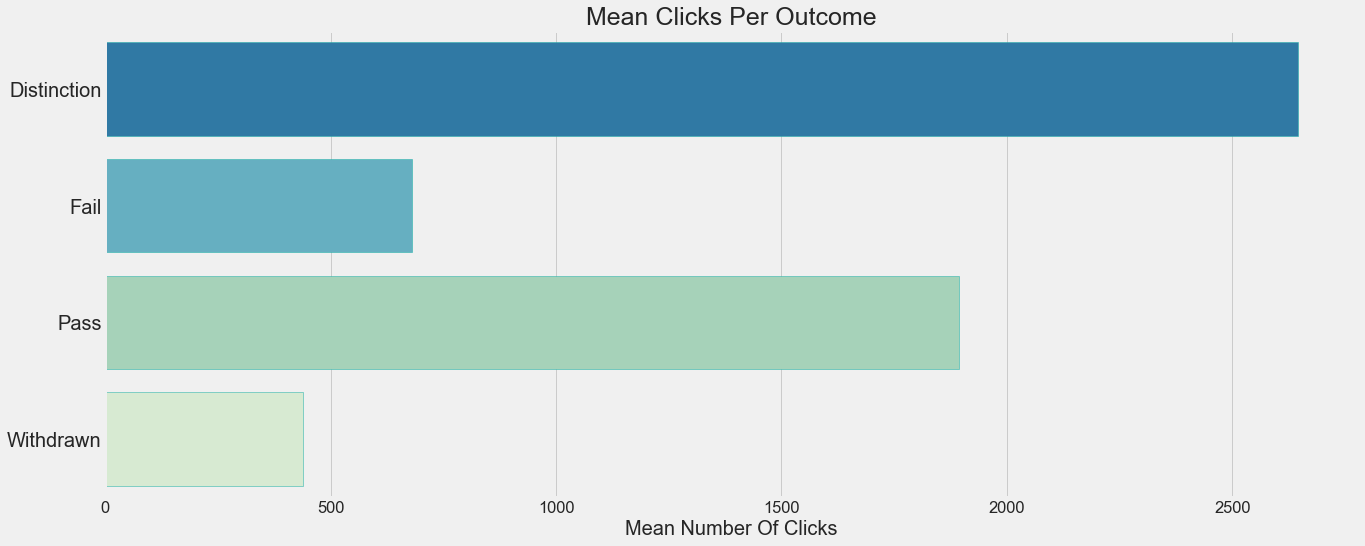

time: 139 ms


In [54]:
v.outcome_clks(sv_si)

In [55]:
sv_si.groupby('final_result')['click_sum'].mean()\
.reset_index(name='mean_clicks').round()

,final_result,mean_clicks
0,Distinction,2647.0
1,Fail,680.0
2,Pass,1894.0
3,Withdrawn,437.0


time: 14.2 ms


### Mean Activities per Outcome

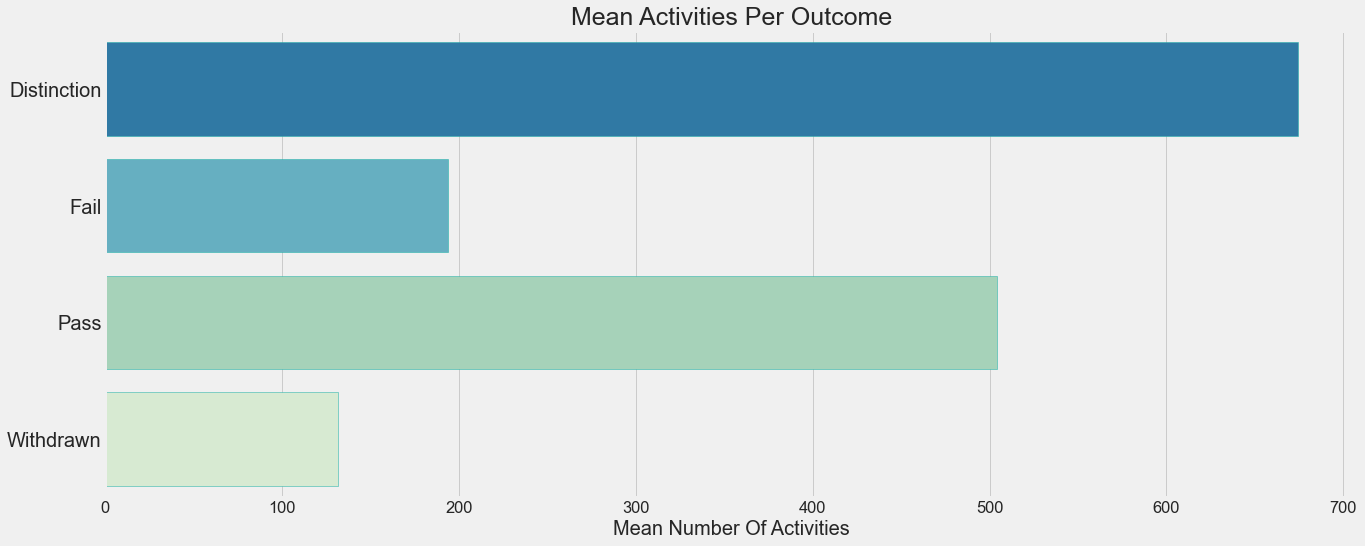

time: 164 ms


In [56]:
v.outcome_nact(sv_si)

In [57]:
sv_si.groupby('final_result')['num_activities'].mean()\
.reset_index(name='mean_activities').round()

,final_result,mean_activities
0,Distinction,675.0
1,Fail,194.0
2,Pass,504.0
3,Withdrawn,131.0


time: 15 ms


## STUDENTVLE Table

In [94]:
svle = db.simple_df('STUDENTVLE')
svle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


time: 28.2 s


In [96]:
conversions = ['date', 'sum_click']
svle[conversions] = svle[conversions].apply(pd.to_numeric)

time: 10.9 s


In [97]:
svle['row_id'] = svle.code_module + svle.code_presentation + svle.id_student

time: 1.86 s


In [99]:
svle = svle.drop(columns=['code_module', 'code_presentation', 'id_student'])

time: 3.31 s


In [100]:
svle.head()

,id_site,date,sum_click,row_id
0,546652,-10,4,AAA2013J28400
1,546652,-10,1,AAA2013J28400
2,546652,-10,1,AAA2013J28400
3,546614,-10,11,AAA2013J28400
4,546714,-10,1,AAA2013J28400


time: 4.88 ms


In [101]:
col_name = 'row_id'
col = svle.pop(col_name)
svle.insert(0, col_name, col)
svle.head()

,row_id,id_site,date,sum_click
0,AAA2013J28400,546652,-10,4
1,AAA2013J28400,546652,-10,1
2,AAA2013J28400,546652,-10,1
3,AAA2013J28400,546614,-10,11
4,AAA2013J28400,546714,-10,1


time: 189 ms


In [102]:
svle.date.min()

-25

time: 16.7 ms


In [103]:
svle['date'] = svle['date'] + 25

time: 51.1 ms


In [104]:
sv_pivot = svle.pivot_table(
    index='date', columns=['row_id'],
    values='sum_click', aggfunc=[np.sum], fill_value=0)

time: 8.25 s


In [105]:
sv_pivot.head(5)

sum                                               \
row_id AAA2013J100893 AAA2013J101781 AAA2013J102806 AAA2013J102952   
date                                                                 
0                   0              0              0              0   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              0              0   
4                   0              0              0              0   

                                                                     \
row_id AAA2013J1035023 AAA2013J104476 AAA2013J106247 AAA2013J106577   
date                                                                  
0                    0              0              0              0   
1                    0              0              0              0   
2                    0              0              0              0   
3                    0              0              0              0   
4                    0              0              0              0   

                                       ...                                \
row_id AAA2013J110175 AAA2013J1105478  ... GGG2014J697364 GGG2014J697492   
date                                   ...                                 
0                   0               0  ...              0              0   
1                   0               0  ...              0              0   
2                   0               0  ...              0              0   
3                   0               0  ...              0              0   
4                   0               0  ...              0              0   

                                                                    \
row_id GGG2014J698019 GGG2014J698065 GGG2014J698163 GGG2014J698460   
date                                                                 
0                   0              0              0              0   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              0              0   
4                   0              0              0              0   

                                                                   
row_id GGG2014J698548 GGG2014J699461 GGG2014J699628 GGG2014J92103  
date                                                               
0                   0              0              0             0  
1                   0              0              0             0  
2                   0              0              0             0  
3                   0              0              0             0  
4                   0              0              0             0  

[5 rows x 29228 columns]

time: 19.3 ms


In [106]:
sv_pivot.columns = sv_pivot.columns.to_flat_index()

time: 7.18 ms


In [107]:
sv_pivot.columns = [sv_pivot.columns[i][1] for i in range(len(sv_pivot.columns))]

time: 38.3 ms


In [108]:
sv_pivot.head()

,AAA2013J100893,AAA2013J101781,AAA2013J102806,AAA2013J102952,AAA2013J1035023,AAA2013J104476,AAA2013J106247,AAA2013J106577,AAA2013J110175,AAA2013J1105478,...,GGG2014J697364,GGG2014J697492,GGG2014J698019,GGG2014J698065,GGG2014J698163,GGG2014J698460,GGG2014J698548,GGG2014J699461,GGG2014J699628,GGG2014J92103
date,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 23.4 ms


In [109]:
sv_pivot = sv_pivot.reset_index(drop=True)

time: 12.7 ms


In [110]:
sv_pivot.head()

,AAA2013J100893,AAA2013J101781,AAA2013J102806,AAA2013J102952,AAA2013J1035023,AAA2013J104476,AAA2013J106247,AAA2013J106577,AAA2013J110175,AAA2013J1105478,...,GGG2014J697364,GGG2014J697492,GGG2014J698019,GGG2014J698065,GGG2014J698163,GGG2014J698460,GGG2014J698548,GGG2014J699461,GGG2014J699628,GGG2014J92103
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 15.1 ms


In [111]:
sv_unpivot = sv_pivot.T

time: 165 ms


In [113]:
sv_unpivot.head()

,0,1,2,3,4,5,6,7,8,9,...,285,286,287,288,289,290,291,292,293,294
AAA2013J100893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAA2013J101781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
AAA2013J102806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
AAA2013J102952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAA2013J1035023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 10.2 ms


In [114]:
sv_unpivot = sv_unpivot.reset_index()

time: 64.1 ms


In [115]:
sv_time = sv_unpivot.rename(columns = {'index': 'row_id'})

time: 15.8 ms


In [116]:
sv_time.head()

,row_id,0,1,2,3,4,5,6,7,8,...,285,286,287,288,289,290,291,292,293,294
0,AAA2013J100893,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAA2013J101781,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
2,AAA2013J102806,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,AAA2013J102952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAA2013J1035023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 12.3 ms


In [119]:
svsi_time = sv_si.merge(sv_time, on='row_id')

time: 170 ms


In [120]:
svsi_time.head()

,target,row_id,final_result,code_module,code_presentation,id_student,id_site,date,click_sum,num_activities,...,285,286,287,288,289,290,291,292,293,294
0,1,AAA2013J100893,Pass,AAA,2013J,100893,547013,-9,744,243,...,0,0,0,0,0,0,0,0,0,0
1,1,AAA2013J101781,Pass,AAA,2013J,101781,546614,-10,4104,913,...,0,0,0,0,0,0,0,0,10,0
2,1,AAA2013J102806,Pass,AAA,2013J,102806,546719,-10,1944,781,...,0,0,0,0,0,0,0,2,0,0
3,1,AAA2013J102952,Pass,AAA,2013J,102952,546879,-3,1150,313,...,0,0,0,0,0,0,0,0,0,0
4,1,AAA2013J1035023,Pass,AAA,2013J,1035023,546652,-10,1896,572,...,0,0,0,0,0,0,0,0,0,0


time: 14 ms


In [122]:
svsi_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28174 entries, 0 to 28173
Columns: 314 entries, target to 294
dtypes: category(1), int64(301), object(12)
memory usage: 67.5+ MB
time: 17.2 ms


In [130]:
svsi_time.isna().sum().value_counts()

0    314
dtype: int64

time: 33.2 ms


## VLE Table

In [131]:
vle = db.simple_df('VLE')
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,None,None
1,546712,AAA,2013J,oucontent,None,None
2,546998,AAA,2013J,resource,None,None
3,546888,AAA,2013J,url,None,None
4,547035,AAA,2013J,resource,None,None


time: 21.1 ms


## COURSES Table

In [132]:
courses = db.simple_df('COURSES')
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


time: 7.71 ms


## ASSESSMENTS Table

In [133]:
assess_df = db.simple_df('ASSESSMENTS')
assess_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19,10
1,AAA,2013J,1753,TMA,54,20
2,AAA,2013J,1754,TMA,117,20
3,AAA,2013J,1755,TMA,166,20
4,AAA,2013J,1756,TMA,215,30


time: 10.7 ms


## STUDENTASSESSMENT Table

In [134]:
stuassess = db.simple_df('STUDENTASSESSMENT')
stuassess.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78
1,1752,28400,22,0,70
2,1752,31604,17,0,72
3,1752,32885,26,0,69
4,1752,38053,19,0,79


time: 323 ms


In [135]:
stuassess.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

time: 46.9 ms


In [136]:
stuassess['score'] = stuassess['score'].apply(pd.to_numeric)

time: 1.62 s


In [137]:
stuassess.sort_values('id_student')

,id_assessment,id_student,date_submitted,is_banked,score
117341,34873,100064,40,0,92.0
127697,34881,100064,185,0,93.0
117963,34874,100064,47,0,92.0
131302,34884,100064,207,0,82.0
126309,34880,100064,185,0,82.0
...,...,...,...,...,...
109571,34865,99993,24,0,69.0
104128,34860,99993,17,0,90.0
110678,34866,99993,98,0,68.0
114290,34870,99993,210,0,55.0


time: 147 ms


In [138]:
scores = stuassess.groupby(['id_student'])['score'].mean().reset_index(name='mean_score')

time: 44.9 ms


In [139]:
mean_scores = pd.DataFrame(scores)

time: 705 µs


In [140]:
mean_scores.head()

,id_student,mean_score
0,100064,89.333333
1,100282,78.000000
2,100561,67.142857
3,1006742,78.500000
4,100788,89.352941


time: 7.2 ms


## STUDENTREGISTRATION Table

In [189]:
stureg = db.simple_df('STUDENTREGISTRATION')
stureg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159,None
1,AAA,2013J,28400,-53,None
2,AAA,2013J,30268,-92,12
3,AAA,2013J,31604,-52,None
4,AAA,2013J,32885,-176,None


time: 67.8 ms


In [190]:
stureg['row_id'] = stureg.code_module + stureg.code_presentation + stureg.id_student

time: 9.93 ms


In [191]:
col_name = 'row_id'
col = stureg.pop(col_name)
stureg.insert(0, col_name, col)

time: 2.27 ms


In [193]:
stureg.head()

,row_id,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA2013J11391,AAA,2013J,11391,-159,None
1,AAA2013J28400,AAA,2013J,28400,-53,None
2,AAA2013J30268,AAA,2013J,30268,-92,12
3,AAA2013J31604,AAA,2013J,31604,-52,None
4,AAA2013J32885,AAA,2013J,32885,-176,None


time: 6.61 ms


## SVSISAA

In [141]:
q="""
SELECT SA.*, 
AVG(SA.score) AS mean_score,
A.*,
SV.*, 
SUM(SV.sum_click) AS click_sum,
COUNT(SV.sum_click) AS num_activities,
SI.*
FROM 
ASSESSMENTS as A
JOIN 
STUDENTASSESSMENT as SA
ON SA.id_assessment = A.id_assessment
JOIN
STUDENTVLE as SV
ON SV.id_student = SA.id_student
JOIN 
STUDENTINFO as SI
ON SV.code_module = SI.code_module
AND SV.code_presentation = SI.code_presentation
AND SV.id_student = SI.id_student
GROUP BY 
A.code_module,
A.code_presentation,
SA.id_student;
"""

SVSISAA = pd.read_sql(q, conn)

time: 9min 34s


In [160]:
SVSISAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25818 entries, 0 to 25817
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_assessment         25818 non-null  object 
 1   id_student            25818 non-null  object 
 2   date_submitted        25818 non-null  object 
 3   is_banked             25818 non-null  object 
 4   score                 25790 non-null  object 
 5   mean_score            25795 non-null  float64
 6   code_module           25818 non-null  object 
 7   code_presentation     25818 non-null  object 
 8   id_assessment         25818 non-null  object 
 9   assessment_type       25818 non-null  object 
 10  date                  25817 non-null  object 
 11  weight                25818 non-null  object 
 12  code_module           25818 non-null  object 
 13  code_presentation     25818 non-null  object 
 14  id_student            25818 non-null  object 
 15  id_site            

In [161]:
SVSISAA.head()

,id_assessment,id_student,date_submitted,is_banked,score,mean_score,code_module,code_presentation,id_assessment,assessment_type,...,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,1752,100893,17,0,63,68.4,AAA,2013J,1752,TMA,...,100893,M,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,N,Pass
1,1752,101781,16,0,84,72.6,AAA,2013J,1752,TMA,...,101781,M,South Region,Lower Than A Level,80-90%,35-55,0,60,N,Pass
2,1752,102806,19,0,80,78.0,AAA,2013J,1752,TMA,...,102806,M,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,N,Pass
3,1752,102952,19,0,76,76.6,AAA,2013J,1752,TMA,...,102952,M,London Region,HE Qualification,60-70%,0-35,0,60,N,Pass
4,1752,1035023,19,0,73,70.0,AAA,2013J,1752,TMA,...,1035023,F,London Region,Lower Than A Level,30-40%,35-55,0,60,N,Pass


time: 16.6 ms


In [177]:
df = SVSISAA.loc[:,~SVSISAA.columns.duplicated()].copy()

time: 19.1 ms


In [178]:
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,mean_score,code_module,code_presentation,assessment_type,date,...,num_activities,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,1752,100893,17,0,63,68.4,AAA,2013J,TMA,19,...,1215,M,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,N,Pass
1,1752,101781,16,0,84,72.6,AAA,2013J,TMA,19,...,4565,M,South Region,Lower Than A Level,80-90%,35-55,0,60,N,Pass
2,1752,102806,19,0,80,78.0,AAA,2013J,TMA,19,...,3905,M,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,N,Pass
3,1752,102952,19,0,76,76.6,AAA,2013J,TMA,19,...,1565,M,London Region,HE Qualification,60-70%,0-35,0,60,N,Pass
4,1752,1035023,19,0,73,70.0,AAA,2013J,TMA,19,...,2860,F,London Region,Lower Than A Level,30-40%,35-55,0,60,N,Pass


time: 16.5 ms


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25818 entries, 0 to 25817
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_assessment         25818 non-null  object 
 1   id_student            25818 non-null  object 
 2   date_submitted        25818 non-null  object 
 3   is_banked             25818 non-null  object 
 4   score                 25790 non-null  object 
 5   mean_score            25795 non-null  float64
 6   code_module           25818 non-null  object 
 7   code_presentation     25818 non-null  object 
 8   assessment_type       25818 non-null  object 
 9   date                  25817 non-null  object 
 10  weight                25818 non-null  object 
 11  id_site               25818 non-null  object 
 12  sum_click             25818 non-null  object 
 13  click_sum             25818 non-null  int64  
 14  num_activities        25818 non-null  int64  
 15  gender             

In [180]:
df['row_id'] = df.code_module + df.code_presentation + df.id_student

time: 15.2 ms


In [182]:
col_name = 'row_id'
col = df.pop(col_name)
df.insert(0, col_name, col)

time: 1.94 ms


In [183]:
df.head()

,row_id,id_assessment,id_student,date_submitted,is_banked,score,mean_score,code_module,code_presentation,assessment_type,...,num_activities,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA2013J100893,1752,100893,17,0,63,68.4,AAA,2013J,TMA,...,1215,M,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,N,Pass
1,AAA2013J101781,1752,101781,16,0,84,72.6,AAA,2013J,TMA,...,4565,M,South Region,Lower Than A Level,80-90%,35-55,0,60,N,Pass
2,AAA2013J102806,1752,102806,19,0,80,78.0,AAA,2013J,TMA,...,3905,M,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,N,Pass
3,AAA2013J102952,1752,102952,19,0,76,76.6,AAA,2013J,TMA,...,1565,M,London Region,HE Qualification,60-70%,0-35,0,60,N,Pass
4,AAA2013J1035023,1752,1035023,19,0,73,70.0,AAA,2013J,TMA,...,2860,F,London Region,Lower Than A Level,30-40%,35-55,0,60,N,Pass


time: 20.9 ms


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25818 entries, 0 to 25817
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   row_id                25818 non-null  object 
 1   id_assessment         25818 non-null  object 
 2   id_student            25818 non-null  object 
 3   date_submitted        25818 non-null  object 
 4   is_banked             25818 non-null  object 
 5   score                 25790 non-null  object 
 6   mean_score            25795 non-null  float64
 7   code_module           25818 non-null  object 
 8   code_presentation     25818 non-null  object 
 9   assessment_type       25818 non-null  object 
 10  date                  25817 non-null  object 
 11  weight                25818 non-null  object 
 12  id_site               25818 non-null  object 
 13  sum_click             25818 non-null  object 
 14  click_sum             25818 non-null  int64  
 15  num_activities     

## Merging Time Data

In [187]:
df = df.merge(sv_time, on='row_id')

time: 196 ms


In [188]:
df.head()

,row_id,id_assessment,id_student,date_submitted,is_banked,score,mean_score,code_module,code_presentation,assessment_type,...,285,286,287,288,289,290,291,292,293,294
0,AAA2013J100893,1752,100893,17,0,63,68.4,AAA,2013J,TMA,...,0,0,0,0,0,0,0,0,0,0
1,AAA2013J101781,1752,101781,16,0,84,72.6,AAA,2013J,TMA,...,0,0,0,0,0,0,0,0,10,0
2,AAA2013J102806,1752,102806,19,0,80,78.0,AAA,2013J,TMA,...,0,0,0,0,0,0,0,2,0,0
3,AAA2013J102952,1752,102952,19,0,76,76.6,AAA,2013J,TMA,...,0,0,0,0,0,0,0,0,0,0
4,AAA2013J1035023,1752,1035023,19,0,73,70.0,AAA,2013J,TMA,...,0,0,0,0,0,0,0,0,0,0


time: 17 ms
